# Flight Predicter



## Setup

This section is regarding the start of spark and pull data from the hdfs database

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .config('spark.ui.port', '4040') \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-09-27 18:09:26,354 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:

df = spark.read.csv('hdfs://localhost:9000/user/flight_data/flights.csv', header=True, inferSchema=True)
df.printSchema()
df.describe().show()



root
 |-- id: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dep_time: double (nullable = true)
 |-- sched_dep_time: integer (nullable = true)
 |-- dep_delay: double (nullable = true)
 |-- arr_time: double (nullable = true)
 |-- sched_arr_time: integer (nullable = true)
 |-- arr_delay: double (nullable = true)
 |-- carrier: string (nullable = true)
 |-- flight: integer (nullable = true)
 |-- tailnum: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- air_time: double (nullable = true)
 |-- distance: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- time_hour: string (nullable = true)
 |-- name: string (nullable = true)



+-------+-----------------+------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-------+------------------+-------+------+------+------------------+------------------+------------------+------------------+-------------------+--------------------+
|summary|               id|  year|             month|              day|          dep_time|    sched_dep_time|         dep_delay|          arr_time|   sched_arr_time|        arr_delay|carrier|            flight|tailnum|origin|  dest|          air_time|          distance|              hour|            minute|          time_hour|                name|
+-------+-----------------+------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-------+------------------+-------+------+------+------------------+------------------+------------------+-----------

In [3]:
df.show()

+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+--------------------+
| id|year|month|day|dep_time|sched_dep_time|dep_delay|arr_time|sched_arr_time|arr_delay|carrier|flight|tailnum|origin|dest|air_time|distance|hour|minute|          time_hour|                name|
+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+--------------------+
|  0|2013|    1|  1|   517.0|           515|      2.0|   830.0|           819|     11.0|     UA|  1545| N14228|   EWR| IAH|   227.0|    1400|   5|    15|2013-01-01 05:00:00|United Air Lines ...|
|  1|2013|    1|  1|   533.0|           529|      4.0|   850.0|           830|     20.0|     UA|  1714| N24211|   LGA| IAH|   227.0|    1416|   5|    29|2013-01-01 05:00:00|United Air Lines ...|
|  2|2013|    1|  1|   54

## Preprocessing

Data preprocessing involves cleaning and transforming the raw data to prepare it for machine learning. This included handling missing values, encoding categorical features.


In [5]:
from pyspark.ml.feature import StringIndexer
from packaging.version import Version


indexer = StringIndexer(inputCol="carrier", outputCol="carrier_index")
origin_indexer = StringIndexer(inputCol="origin", outputCol="origin_index")
dest_indexer = StringIndexer(inputCol="dest", outputCol="dest_index")

df = indexer.fit(df).transform(df)
df = origin_indexer.fit(df).transform(df)
df = dest_indexer.fit(df).transform(df)

The below code block is the preprocessing of handling null values, particularly arr_delay. If any entry does not have a value for arr_delay, it will be calculated for using the other provided values such as arr_time and sched_arr_time. If there is no combination of data that can result in an arr_delay value, the entry will be dropped as an estimation would require too many calculations specific to that entry. 

In [18]:
from pyspark.sql.functions import col, when

df_prossesing = df.withColumn(
    'arr_delay',
    when(
        col('arr_delay').isNull() & col('arr_time').isNotNull() & col('sched_arr_time').isNotNull(),
        col('arr_time') - col('sched_arr_time')
    ).when(
        col('arr_delay').isNull() & col('dep_time').isNotNull() & col('air_time').isNotNull() & col('sched_arr_time').isNotNull(),
        (
            col('dep_time') + col('air_time') - col('sched_arr_time') +
            when(col('day') < col('sched_arr_time'), 240).otherwise(0)
        )
    ).otherwise(col('arr_delay'))  
)


df_prossesing = df_prossesing.withColumn(
    "air_time",
    when(
        col("air_time").isNull() & col("arr_time").isNotNull() & col("dep_time").isNotNull(),
        (col("arr_time") - col("dep_time")) + when(col('arr_time') < col('dep_time'), 240).otherwise(0)  
    ).otherwise(col("air_time"))
)

df_prossesing = df_prossesing.withColumn("delayed", (df_prossesing["arr_delay"] > 15).cast("integer"))


df_prossesing.show(truncate=False)


+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+------------------------+-------------+------------+----------+-------+
|id |year|month|day|dep_time|sched_dep_time|dep_delay|arr_time|sched_arr_time|arr_delay|carrier|flight|tailnum|origin|dest|air_time|distance|hour|minute|time_hour          |name                    |carrier_index|origin_index|dest_index|delayed|
+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+------------------------+-------------+------------+----------+-------+
|0  |2013|1    |1  |517.0   |515           |2.0      |830.0   |819           |11.0     |UA     |1545  |N14228 |EWR   |IAH |227.0   |1400    |5   |15    |2013-01-01 05:00:00|United Air Lines Inc.   |0.0          |0.0         |15.0      |0      |
|1  |2013|1    |1  |

Example of a fixed row

In [19]:
row_with_id_733_fixed = df_prossesing.filter(col("id") == 733)
row_with_id_733 = df.filter(col("id") == 733)

row_with_id_733.show(truncate=False)

row_with_id_733_fixed.show(truncate=False)


+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+------------------------+-------------+------------+----------+
|id |year|month|day|dep_time|sched_dep_time|dep_delay|arr_time|sched_arr_time|arr_delay|carrier|flight|tailnum|origin|dest|air_time|distance|hour|minute|time_hour          |name                    |carrier_index|origin_index|dest_index|
+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+------------------------+-------------+------------+----------+
|733|2013|1    |1  |1952.0  |1930          |22.0     |2358.0  |2207          |null     |EV     |4333  |N11194 |EWR   |TUL |null    |1215    |19  |30    |2013-01-01 19:00:00|ExpressJet Airlines Inc.|2.0          |0.0         |80.0      |
+---+----+-----+---+--------+--------------+--------

This shows the amount of null/nan data row after and before

In [29]:
from pyspark.sql.functions import col, isnan
from functools import reduce

missing_rows = df_prossesing.filter(
    reduce(lambda a, b: a | b, [col(c).isNull() | isnan(c) for c in df_prossesing.columns])
)

missing_rows2 = df.filter(
    reduce(lambda a, b: a | b, [col(c).isNull() | isnan(c) for c in df.columns])
)

count_missing_rows_1 = missing_rows.count()
count_missing_rows_2 = missing_rows2.count()

print(f"Missing rows in df_prossesing: {count_missing_rows_1}")
print(f"Missing rows in df: {count_missing_rows_2}")



Missing rows in df_prossesing: 8713
Missing rows in df: 9430


Drop the rest of null/nan data rows

In [39]:
df_processed = df_prossesing.dropna()

df_processed.count()


328063

### Data Visualisation
This subsection is for visualise the delay distribution and balance the data

categorizing the data 

In [42]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

df_processed_categorized = df_processed.withColumn(
    "delay_category",
    when(col("arr_delay") <= 0, "On time")
    .when((col("arr_delay") > 0) & (col("arr_delay") <= 15), "Short delay")
    .when((col("arr_delay") > 15) & (col("arr_delay") <= 60), "Moderate delay")
    .when(col("arr_delay") > 60, "Long delay")
    .otherwise("Unknown")  
)




Balancing the data, this will not make it exactly even, but aprox

In [65]:
from pyspark.sql.functions import col

category_counts = df_processed_categorized.groupBy("delay_category").count()

min_count = category_counts.agg(F.min("count")).collect()[0][0]

df_processed_balanced = df_processed_categorized.join(
    category_counts,
    on="delay_category",
    how="inner"
).withColumn(
    "sampling_ratio", (min_count / col("count"))
).withColumn("rand", F.rand()).where(F.col("rand") < F.col("sampling_ratio"))

df_processed_balanced.groupBy("delay_category").count().show()



+--------------+-----+
|delay_category|count|
+--------------+-----+
|       On time|28705|
|Moderate delay|28478|
|   Short delay|28612|
|    Long delay|28402|
+--------------+-----+



28402

Just to visualise the distribution after and before balancing the data

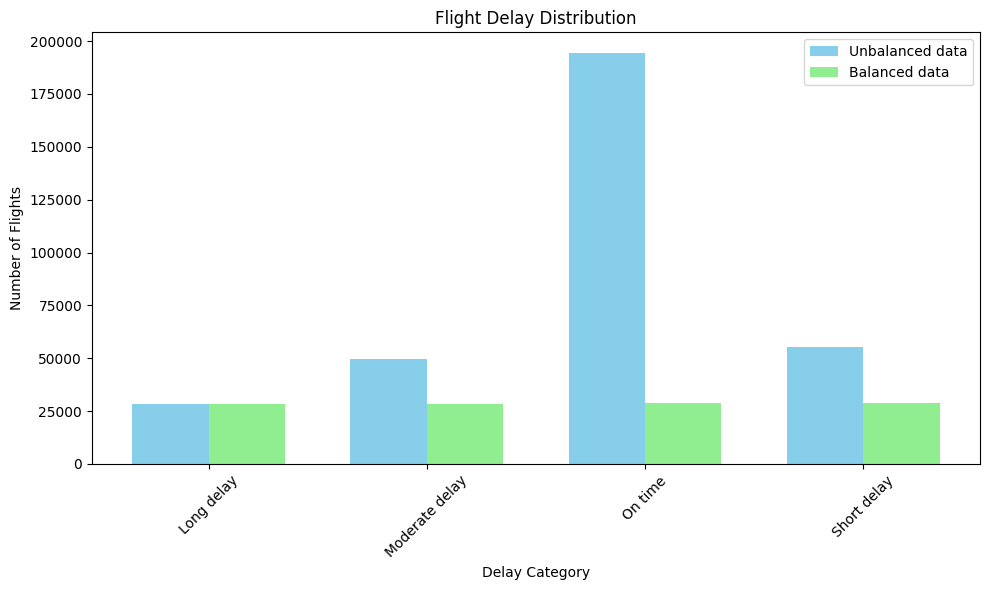

In [66]:
import matplotlib.pyplot as plt
import numpy as np

delay_distribution = df_processed_categorized.groupBy("delay_category").count().collect()
categories = [row["delay_category"] for row in delay_distribution]
counts = [row["count"] for row in delay_distribution]

df_balanced_distribution = df_processed_balanced.groupBy("delay_category").count().collect()
categories_balanced = [row["delay_category"] for row in df_balanced_distribution]
counts_balanced = [row["count"] for row in df_balanced_distribution]

sorted_indices = np.argsort(categories)
categories = np.array(categories)[sorted_indices]
counts = np.array(counts)[sorted_indices]

sorted_indices_balanced = np.argsort(categories_balanced)
categories_balanced = np.array(categories_balanced)[sorted_indices_balanced]
counts_balanced = np.array(counts_balanced)[sorted_indices_balanced]

bar_width = 0.35
index = np.arange(len(categories))

plt.figure(figsize=(10, 6))

plt.bar(index, counts, bar_width, label='Unbalanced data', color='skyblue')

plt.bar(index + bar_width, counts_balanced, bar_width, label='Balanced data', color='lightgreen')

plt.title("Flight Delay Distribution")
plt.xlabel("Delay Category")
plt.ylabel("Number of Flights")
plt.xticks(index + bar_width / 2, categories, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


## modellering och träning
This section is where the ML takes place.

In [64]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession


This code creates a feature vector for the ML.

**feature_cols** defines the columns to be used as input features.
**VectorAssembler** combines these columns into a new "features" column. 
**df_transformed** adds this "features" column to the DataFrame, preparing it for model training.

In [67]:
feature_cols = ["dep_delay", "distance", "carrier_index", "air_time", "origin_index", "dest_index", "month"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_transformed = assembler.transform(df_processed_balanced)

Split the data into two types, training and testing data

In [68]:
train_data,  test_data = df_transformed.randomSplit([0.7, 0.3], seed=42)

This code initializes a **LogisticRegression** with the **features** and **delayed** as the label (the target variable that the model is trying to predict).

In [69]:
lr = LogisticRegression(featuresCol="features", labelCol="delayed")
lr_model = lr.fit(train_data)



2024-09-27 18:37:08,569 WARN netlib.InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
2024-09-27 18:37:08,579 WARN netlib.InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


This code uses the trained lr-model to make predictions on the test_data. Then, the BinaryClassificationEvaluator is used to evaluate the model's performance by calculating an accuracy score, with delayed as the label.

In [70]:
predictions = lr_model.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="delayed")
accuracy = evaluator.evaluate(predictions)

print(f"Model Accuracy: {accuracy}")


Model Accuracy: 0.9262877176366102


This code generates a confusion matrix plot to visualize the performance of the lr-model in predicting flight delays.

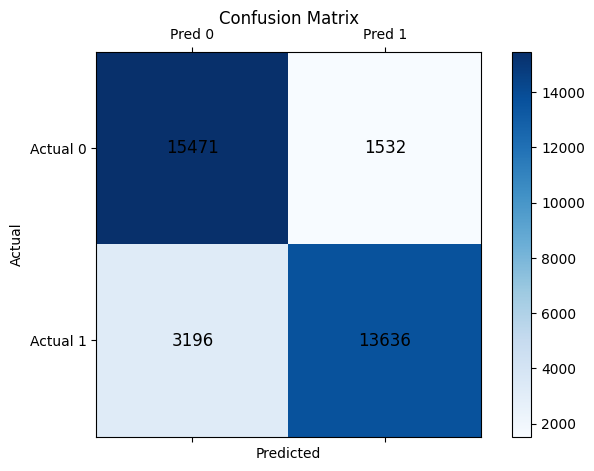

In [71]:
import matplotlib.pyplot as plt
import numpy as np

confusion_matrix = predictions.groupBy("delayed", "prediction").count().collect()

cm = np.zeros((2, 2))
for row in confusion_matrix:
    actual = int(row["delayed"])
    predicted = int(row["prediction"])
    cm[actual][predicted] = row["count"]

fig, ax = plt.subplots(figsize=(8, 5))
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix', pad=20)
fig.colorbar(cax)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Pred 0", "Pred 1"])
ax.set_yticklabels(["Actual 0", "Actual 1"])

plt.xlabel('Predicted')
plt.ylabel('Actual')

# Lägg till siffror i cellerna
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{int(cm[i, j])}', ha='center', va='center', color='black', fontsize=12)

plt.show()

